### Data Ingestion

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load the datasets
users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")



### 1) Calculating Adoption Rate

Adoption Rate: 13.80%


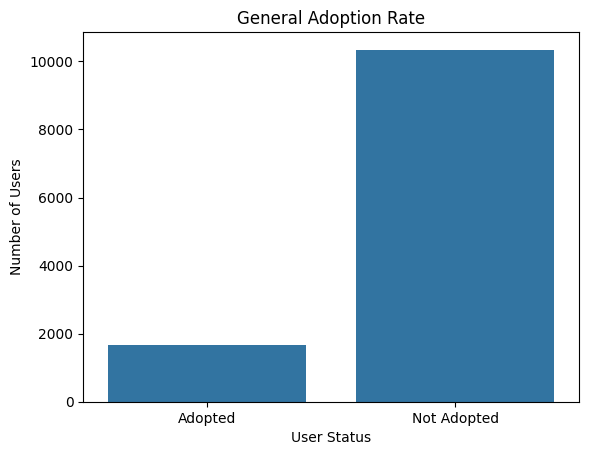

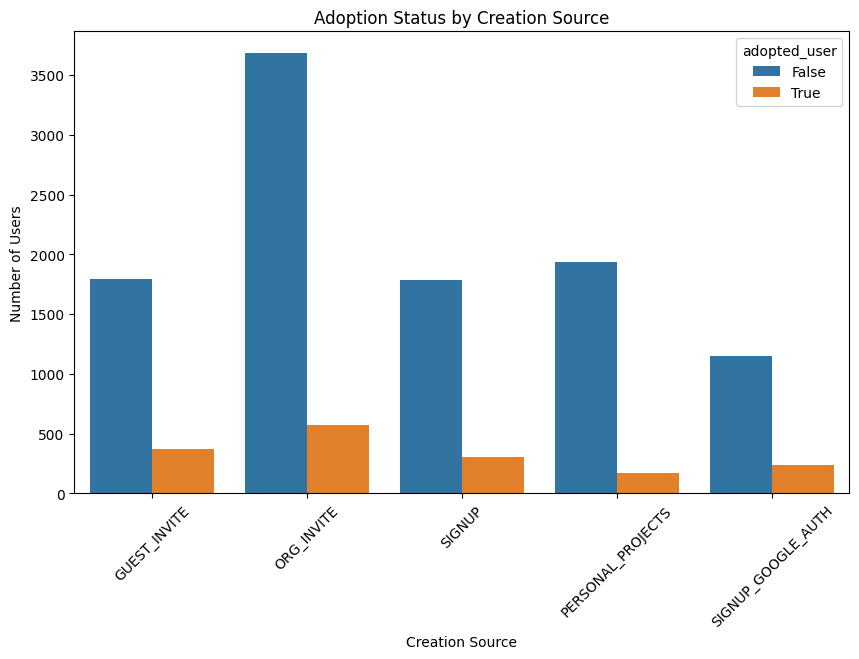

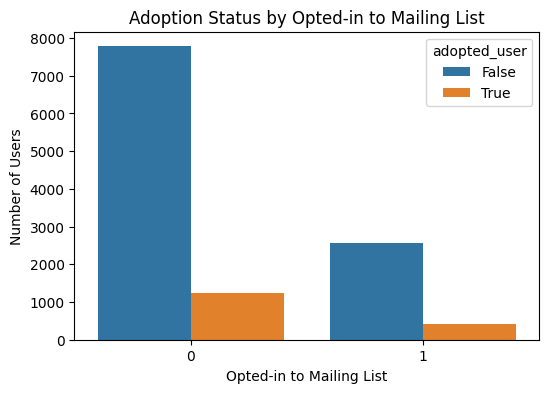

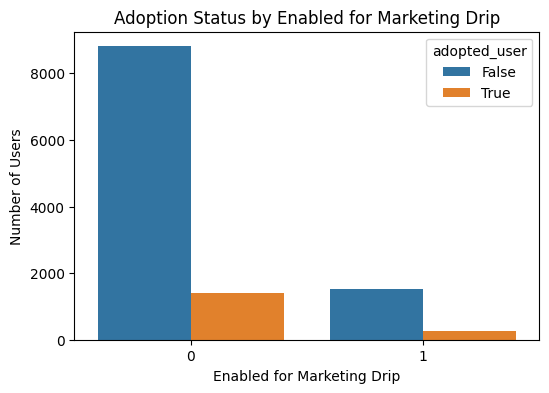

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      2063
           1       0.17      0.30      0.21       337

    accuracy                           0.69      2400
   macro avg       0.52      0.53      0.51      2400
weighted avg       0.77      0.69      0.73      2400



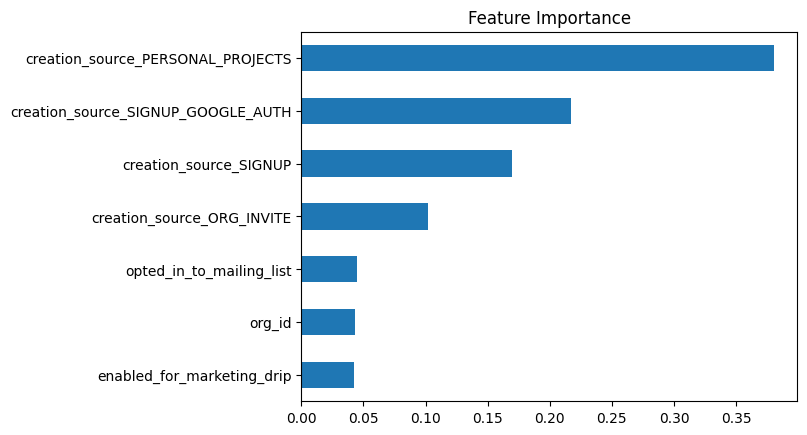

In [ ]:
# Convert the 'time_stamp' in user_engagement to datetime format
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

# Extract the date (without time) for easier comparison
user_engagement['date'] = user_engagement['time_stamp'].dt.date

# Sort by user_id and date
user_engagement = user_engagement.sort_values(['user_id', 'date'])

# Group by user_id and apply a custom function to find adopted users
def is_adopted(dates):
    unique_dates = set()
    for i in range(len(dates)):
        start_date = dates[i]
        within_window = {start_date}
        for j in range(i + 1, len(dates)):
            if (dates[j] - start_date).days <= 7:
                within_window.add(dates[j])
            else:
                break
        if len(within_window) >= 3:
            return True
    return False


adopted_users = user_engagement.groupby('user_id')['date'].apply(lambda x: is_adopted(list(x))).reset_index()

# Filter to find only adopted users
adopted_users = adopted_users[adopted_users['date'] == True]['user_id'].unique()

# Add a new column to the 'users' dataframe to indicate whether a user is adopted
users['adopted_user'] = users['object_id'].isin(adopted_users)

# Calculate the total number of users
total_users = len(users)

# Calculate the number of adopted users
total_adopted_users = users['adopted_user'].sum()

# Calculate the adoption rate
adoption_rate = total_adopted_users / total_users * 100


print(f"Adoption Rate: {adoption_rate:.2f}%")

# Visualize the general adoption rate
data = {'Status': ['Adopted', 'Not Adopted'],
        'Count': [total_adopted_users, total_users - total_adopted_users]}
adoption_df = pd.DataFrame(data)

sns.barplot(x='Status', y='Count', data=adoption_df)
plt.title('General Adoption Rate')
plt.ylabel('Number of Users')
plt.xlabel('User Status')
plt.show()


# Distribution of creation_source
plt.figure(figsize=(10, 6))
sns.countplot(data=users, x='creation_source', hue='adopted_user')
plt.title('Adoption Status by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

# Distribution of opted_in_to_mailing_list
plt.figure(figsize=(6, 4))
sns.countplot(data=users, x='opted_in_to_mailing_list', hue='adopted_user')
plt.title('Adoption Status by Opted-in to Mailing List')
plt.xlabel('Opted-in to Mailing List')
plt.ylabel('Number of Users')
plt.show()

# Distribution of enabled_for_marketing_drip
plt.figure(figsize=(6, 4))
sns.countplot(data=users, x='enabled_for_marketing_drip', hue='adopted_user')
plt.title('Adoption Status by Enabled for Marketing Drip')
plt.xlabel('Enabled for Marketing Drip')
plt.ylabel('Number of Users')
plt.show()

# Drop non-numeric columns for correlation heatmap
users_numeric = users.select_dtypes(include=['number', 'bool'])




# Prepare data for modeling
X = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']]
y = users['adopted_user'].astype(int)

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Fit XGBoost model on balanced data
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions and evaluate the model
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()


### 2) Methodology

To understand what factors influence user adoption and to help Asana improve the user onboarding experience, I performed an analysis using historical data on user signups and engagement.

First, I defined an "adopted user" as someone who logged into the platform on at least three separate days within a seven-day period. To calculate this, I processed the user engagement data by converting login timestamps into a simpler date format. I then grouped user login data by user ID and applied a function to check if any users met the criteria for adoption.

After identifying the adopted users, I merged this information with the main user dataset. This allowed me to calculate the overall adoption rate, which was 13.80%. I also explored how different user characteristics, such as the method of signup (creation_source), opting into the mailing list, and participation in marketing drip campaigns, influenced adoption. Visualizations showed, for example, that users who signed up via personal projects or Google authentication had higher adoption rates compared to those invited as guests to organizations.

Next, I prepared the data for modeling. I selected key features (signup source, mailing list opt-in, marketing drip participation, and organization ID) and encoded them. To address the imbalance between adopted and non-adopted users, I applied the SMOTE technique, which helps balance the data by oversampling the minority class (adopted users).

Finally, I trained an XGBoost model to predict whether a user would become adopted. The model was evaluated on a test set, and the results provided insights into the factors that contribute most to user adoption. These insights can guide Asana’s product and engineering teams, particularly by focusing on optimizing the signup process and early engagement strategies to increase user adoption.

### 3) What Factors Predict User Adoption?

Our analysis identified key factors that influence user adoption in Asana. The most significant predictor is the signup method: users who sign up via personal projects or Google authentication are more likely to adopt the platform, while those invited as guests to organizations show lower adoption rates. Additionally, opting into marketing emails and participating in marketing drip campaigns contribute modestly to adoption, suggesting that ongoing communication helps keep users engaged. To improve adoption, I recommend focusing on promoting high-performing signup methods, such as Google authentication, and enhancing onboarding experiences for guest invitees. Additionally, strengthening personalized content in marketing emails and campaigns could further boost user engagement and retention. Behavioral insights like the frequency of user interactions within the first week or how users engage with specific features could offer deeper predictive power beyond the initial signup method. Tracking in-app activity such as task creation or team collaboration may reveal more actionable patterns that correlate with long-term adoption. Additionally, A/B testing different onboarding flows, especially for guest invitees, could help optimize the user experience for different segments. Finally, while marketing drip campaigns and email opt-ins have a modest effect on adoption, experimenting with more targeted, behavior-driven communications might yield better results. These efforts combined could help Asana fine-tune the onboarding process and maximize user retention.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 4) Additional Commentary (Optional)

The model performs well in predicting non-adopted users, with an F1-score of
 0.81, but struggles with adopted users, achieving a low F1-score of 0.21. This is likely due to the imbalance in the dataset, despite applying SMOTE. While the overall accuracy is 0.69, improving predictions for adopted users will require further tuning, such as adjusting the classification threshold or exploring additional features to enhance the model's performance in identifying adopted users.








